# 2.8 Multi-Agent 시스템과 RouteLLM

- 앞에서 개발한 `소득세 에이전트`와 `종합부동산세 에이전트`를 활용해서 다중 에이전트 시스템을 구현합니다

In [19]:
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

small_llm = ChatOpenAI(model="gpt-4o-mini")

In [21]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'."""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'llm']:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['income_tax', 'real_estate_tax', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})

    return route.target

In [23]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

- `node`를 추가하고 `edge`로 연결합니다
    - 앞에서 개발한 `agent`들을 `node`로 활용할 수 있습니다

In [24]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/sangjinsu/projects/inflearn-langgraph-lecture/real_estate_tax_graph.py:92: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  from langchain_community.tools import TavilySearchResults


In [25]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm'
    }
)
graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [26]:
graph = graph_builder.compile()

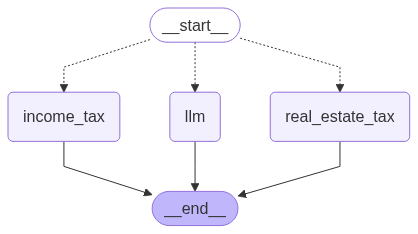

In [27]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
initial_state = {'query': '소득세란 무엇인가요?'}
graph.invoke(initial_state)

{'query': '소득세란 무엇인가요?',
 'context': [Document(id='c3d95c37-2b30-4784-bfc1-51691e476b39', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\

In [29]:
initial_state = {
    'query': '집 15억은 세금을 얼마나 내나요?'
}

graph.invoke(initial_state)

{'query': '집 15억은 세금을 얼마나 내나요?',
 'answer': '주어진 정보를 바탕으로 기본적인 계산 과정을 설명드리겠습니다. 우선 공정시장가액을 구하셨습니다.\n\n1. **공정시장가액:** 15억 원 × 60% = 9억 원\n\n공정시장가액만으로는 종합부동산세를 계산할 수 없습니다. 종합부동산세 계산에는 부양공제, 감면 혜택, 그리고 적용되는 세율이 필요합니다. \n\n### 추가적으로 필요한 정보:\n- **1세대 1주택인지 여부**: 1세대 1주택자인 경우 특별공제 혜택이 있을 수 있습니다.\n- **공제 금액:** 기본 공제 금액이 주택 종류 및 정책에 따라 다를 수 있습니다.\n- **적용되는 세율:** 주택 수와 과세표준에 따라 세율이 다릅니다.\n- **기타 감면 사항:** 정책에 따라 달라질 수 있습니다.\n\n국세청의 관련 규정을 통해 세율 구간을 확인하고, 해당 과세표준과 조건에 맞는 세율을 적용해야 합니다.\n\n정확한 세금을 계산하기 위해서는 위와 같은 추가적인 정보가 필요합니다. 세부 정보가 부족한 관계로 일반적인 계산에서 벗어나기 어렵습니다. 국세청 또는 관련 세무 담당 기관에 문의하시어 최신 정보와 규정에 따라 종합부동산세를 계산하시길 권장합니다.'}

In [30]:
initial_state = {'query': '떡볶이는 어디가 맛있나요?'}
graph.invoke(initial_state)

{'query': '떡볶이는 어디가 맛있나요?',
 'answer': '떡볶이를 맛있게 먹을 수 있는 장소는 여러 곳이 있습니다. 지역마다 유명한 떡볶이 집이 많으니, 몇 가지 추천해 드리겠습니다.\n\n1. **서울**: 명동, 홍대, 신촌 등에는 다양한 떡볶이 가게가 있습니다. 특히 "신전떡볶이"와 "이태원 떡볶이"가 인기입니다.\n  \n2. **부산**: 부산 해운대나 서면 지역에는 "부산 할매 떡볶이"와 같은 유명한 가게가 많습니다.\n\n3. **대전**: "대전 떡볶이"는 매운 떡볶이를 좋아하는 사람들에게 추천할 만한 곳입니다.\n\n4. **광주**: 광주에서는 "광주 떡볶이"가 유명하며, 독특한 맛을 즐길 수 있습니다.\n\n각 지역마다 떡볶이의 스타일과 맛이 다르니, 여행하면서 다양한 곳을 찾아보는 것도 좋습니다!'}